In [7]:
import argparse
import logging
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
plt.set_loglevel("info")
import uproot 
import awkward as ak
from pathlib import Path
import os 

from typing import Dict, List 
import re
import pickle
from tqdm import tqdm

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from  LightGBM_BDT_train import plot_decision_func, plot_ROC, plot_overtraining_validation


In [2]:
sample_path = '/global/cfs/projectdirs/atlas/hrzhao/HEP_Repo/QG_Calibration/BDT_EB4/samples/sample_testweight_123'
training_vars = ['jet_pt', 'jet_nTracks', 'jet_trackWidth', 'jet_trackC1']
training_weight = ['flatpt_weight']
gbdt_filename = './gbdt.model'

label_pt_bin = [500, 600, 800, 1000, 1200, 1500, 2000]


In [3]:
sample = pd.read_pickle(sample_path)

In [4]:
X = sample.iloc[:, :-1]
y = sample.iloc[:, -1]

X_dev,X_eval, y_dev,y_eval = train_test_split(X, y, test_size=0.1, random_state=456)
X_train, X_test, y_train, y_test = train_test_split(X_dev, y_dev, test_size=0.1/0.9, random_state=789)

event_weight_idx = X.columns.get_loc('event_weight')
equal_weight_idx = X.columns.get_loc('equal_weight')
flatpt_weight_idx = X.columns.get_loc('flatpt_weight')


In [5]:
param = {'num_leaves': 31, 'objective': 'binary'}
param['metric'] = 'auc'

In [16]:
train_data = lgb.Dataset(X_train[training_vars], label=y_train, feature_name=training_vars)
val_data = lgb.Dataset(X_test[training_vars], label=y_test, feature_name=training_vars)
num_round = 10
bst = lgb.train(param, train_data, num_round, valid_sets=val_data)
bst.predict(X_eval[training_vars])

In [31]:
# make predictions using lightgbm for classification
from sklearn.datasets import make_classification
from lightgbm import LGBMClassifier
# define dataset
# X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=7)
# define the model
model = LGBMClassifier(random_state=42)
# fit the model on the whole dataset
model.fit(X_train[training_vars].values, y_train.values)

LGBMClassifier(random_state=42)

In [37]:
y_decision_score = model.predict(X_eval[training_vars].values, raw_score=True)

(array([  52.,  159.,  196.,  343.,  416.,  415.,  506.,  476.,  614.,
         625.,  850.,  738.,  911., 1042., 1278., 1987., 2500., 3261.,
        3589., 3646., 3634., 3910., 4020., 4014., 3933., 4393., 3927.,
        4098., 4194., 4040., 4216., 4209., 4137., 4063., 4284., 4297.,
        4432., 4335., 4563., 4308., 4500., 4484., 4520., 4617., 4594.,
        4645., 4748., 4724., 4652., 4644., 4987., 4988., 5126., 5422.,
        5591., 5211., 5238., 5363., 4999., 5132., 5134., 4836., 4629.,
        4492., 4234., 4131., 3870., 3605., 3464., 3228., 3006., 2933.,
        2737., 2568., 2528., 2491., 2153., 2112., 1952., 1867., 1751.,
        1575., 1472., 1315., 1186., 1050.,  888.,  753.,  670.,  520.,
         404.,  305.,  241.,  157.,  104.,   79.,   55.,   29.,    6.,
           8.]),
 array([-4.84636607, -4.77026187, -4.69415766, -4.61805346, -4.54194925,
        -4.46584505, -4.38974084, -4.31363663, -4.23753243, -4.16142822,
        -4.08532402, -4.00921981, -3.93311561, -3.857011

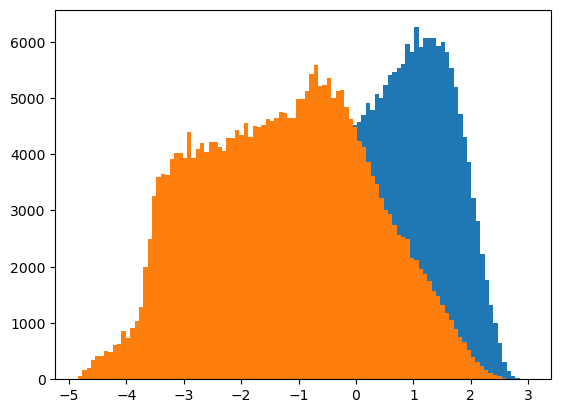

In [41]:
plt.hist(y_decision_score[y_eval == 1], bins = 100)
plt.hist(y_decision_score[y_eval == 0], bins = 100)
